![Rossmann](rossmann_mark.jpg)

Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

Rossmann is challenging you to predict 6 weeks of daily sales for 1,115 stores located across Germany. Reliable sales forecasts enable store managers to create effective staff schedules that increase productivity and motivation.    




---
## Flow

Here we present EDA (Explotary Data Analysis), followed by description of model and training. We then conclude with comparison of model performance.

---
## What kind of problem to solve?
This task can be seen as regression or time series problem. Here we propose regression method with embedding features method to mine the data information.

In [2]:
%reload_ext autoreload
%autoreload 2

import os, sys, numpy as np, pandas as pd, tensorflow as tf
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from datetime import datetime, timedelta
from matplotlib import pyplot as plt
# plt.style.use('ggplot')
plt.style.use('seaborn-whitegrid') # 

ctx = os.path.abspath(os.path.dirname('.'))
if ctx not in sys.path:
    sys.path.insert(0, ctx)

from trainer import utils
from trainer import app_conf, metadata, input as inp, service
from trainer.ctrl import Ctrl

np.set_printoptions(precision=4, suppress=True, linewidth=100)
np.warnings.filterwarnings('ignore')

## Preview

## Metadata description
---
Columns       | Descriptions 
--------------|-------
Id|An Id that represents a (Store, Date) duple within the test set
Store|A unique Id for each store
Sales|The turnover on a given day (our target variable)
Customers|The number of customers on a given day
Open|open: 0 = the store is closed , 1 = the store is open
StateHoliday|Indicates a state holiday. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
SchoolHoliday|Store on this Date was affected or not by the closure of public schools
StoreType|4 different stores:a,b,c,d
Assortment|Assortment level: a = basic, b = extra, c = extended
CompetitionDistance|Distance in meters to the nearest competitor store
CompetitionOpenSince[Month/Year]|gives the approximate year and month of the time the nearest competitor was opened
Promo|Promo or not on that day
Promo2|Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
Promo2Since[Year/Week]|describes the year and calendar week when the store started participating in Promo2
PromoInterval|describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [24]:
utils.preview('./data/train.csv')

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [25]:
utils.preview('./data/store.csv')

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9,2008,0,NaN,NaN,NaN
1,2,a,a,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9,2009,0,NaN,NaN,NaN
4,5,a,a,29910.0,4,2015,0,NaN,NaN,NaN


In [26]:
utils.preview('./data/store_states.csv')

,Store,State
0,1,HE
1,2,TH
2,3,NW
3,4,BE
4,5,SN


## Data Exploration
First, we add columns `year, month, day, promo2, sales_mean, customers_mean, competition_open_since, promo2since`
- We treat `year, month, day` as categorical variables. We expect there to be perhaps some peak hour or off-peak time on specific day; continuous variables cannot handle this well.
- `promo2` is a continuing and consecutive promotion campaign, which is periodical per year. It can be obtained with `store.Promo2` and `store.PromoInterval` columns.
- Both `sales_mean` and `customers_mean` columns are average of sales and customers per store. These attributes can decently secure the quantities.
- `competition_open_since` is the time of appearance of nearby competition, represented as number of days after 1970/01/01.
- `promo2since` is the earliest time of periodical promotion, also represented as number of days after 1970/01/01

### Clean Data and Add Feature
- We change the header of feature columns to underline separation, e.g: `CompetitionDistance` ==> `competition_distance`

In [3]:
%%time
_ = inp.Input.instance.clean('./data/train.csv')

dtype = inp.Input.instance.get_processed_dtype()
tr = pd.read_csv('./data/processed/cleaned/tr.csv', dtype=dtype)
store = pd.read_csv('./data/processed/cleaned/store.csv', dtype=dtype)
store_states = pd.read_csv('./data/processed/cleaned/store_states.csv', dtype=dtype)

store['competition_distance'] = store.competition_distance.fillna(store.competition_distance.median())

# Add columns `CompetitionOpenSince`, according to date `CompetitionOpenSinceYear` + `CompetitionOpenSinceMonth`,
# to calcucate scaler from 1970/01/01 to which
def map_fn(e):
    y, m = e
    if pd.isna(y) or pd.isna(m): return np.nan
    # y, m = int(float(y)), int(float(m))
    return f'{y}-{m}-1'
since_dt = pd.Series(list(zip(store.competition_open_since_year, store.competition_open_since_month)))\
             .map(map_fn, na_action='ignore')
store['competition_open_since'] = (pd.to_datetime(since_dt) - datetime(1970, 1, 1)).dt.days
store['competition_open_since'].fillna(store['competition_open_since'].median(), inplace=True)
# Add columns `Promo2Since`, according to date `Promo2SinceYear` + `Promo2SinceWeek`,
# to calcucate scaler from 1970/01/01 to which
def promo2_fn(e):
    y, week = e
    if pd.isna(y) or pd.isna(week): 
        return np.nan
    return (datetime.strptime(f'{y}', '%Y') + timedelta(weeks=int(week)) - datetime(1970, 1, 1)).days
store['promo2since'] = pd.Series(list(zip(store.promo2since_year, store.promo2since_week))).map(promo2_fn)
store['promo2since'].fillna(store['promo2since'].median(), inplace=True)

tr_merge = tr.merge(store, how='left', on='store').merge(store_states, how='left', on='store')
tr_merge['state_holiday'] = tr_merge.state_holiday.map(str)

# Alter datatype and fill NaN value to 0
for col in ('competition_open_since_month', 'competition_open_since_year', 'promo2since_week', 'promo2since_year'):
    tr_merge[col] = tr_merge[col].map(int, na_action='ignore').fillna(0)

# Construct year, month, day columns, maybe on sepicific day or period will has some trends.
dt = pd.to_datetime(tr_merge.date)
tr_merge['year'] = dt.dt.year.map(str)
tr_merge['month'] = dt.dt.month.map(str)
tr_merge['day'] = dt.dt.day.map(str)

# Promo2 is a continuing and consecutive promotion campaign, which have periodicity per year
# it can calculate according to store.Promo2 and store.PromoInterval columns
tr_merge['promo2'] = Ctrl.instance.input.cal_promo2(tr_merge)

# Construct customers mean and sales mean columns, at least we know whether this store is popular
tr_merge['sales_mean'] = tr_merge.groupby('store').sales.mean().reindex(tr_merge.store).values
tr_merge['customers_mean'] = tr_merge.groupby('store').customers.mean().reindex(tr_merge.store).values

2018-08-13 14:20:27,671 - trainer.input - INFO [line:22] - Clean start, is_serving: False
2018-08-13 14:20:35,013 - trainer.input - INFO [line:51] - Clean take time 0:00:07.340720
Wall time: 18.2 s


In [4]:
tr_merge.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,promo2since_year,promo_interval,competition_open_since,promo2since,state,year,month,day,sales_mean,customers_mean
0,1,5,2015-07-31,5263.0,555.0,1,1,0,1,c,...,0.0,NaN,14123.0,15438.0,HE,2015,7,31,3945.704883,467.646497
1,2,5,2015-07-31,6064.0,625.0,1,1,0,1,a,...,2010.0,"Jan,Apr,Jul,Oct",13818.0,14701.0,TH,2015,7,31,4122.991507,486.045648
2,3,5,2015-07-31,8314.0,821.0,1,1,0,1,a,...,2011.0,"Jan,Apr,Jul,Oct",13483.0,15073.0,NW,2015,7,31,5741.253715,620.286624
3,4,5,2015-07-31,13995.0,1498.0,1,1,0,1,c,...,0.0,NaN,14488.0,15438.0,BE,2015,7,31,8021.769639,1100.057325
4,5,5,2015-07-31,4822.0,559.0,1,1,0,1,a,...,0.0,NaN,16526.0,15438.0,SN,2015,7,31,3867.110403,444.360934


### Filter some rows
We found that on store closing day, sales equals 0 (for sure). So we drop `open = 0`.

promo
0    2.771974e+09
1    3.101206e+09
Name: sales, dtype: float64


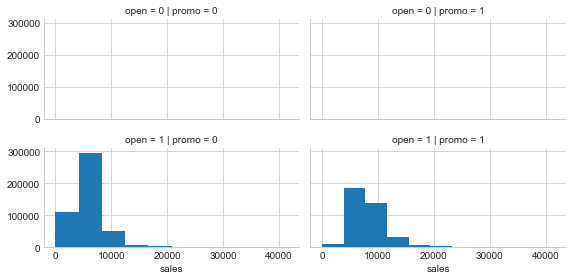

In [5]:
print(tr_merge.groupby('promo').sales.sum())
g = sns.FacetGrid(tr_merge, row='open', col='promo', size=2, aspect=2)
g = g.map(plt.hist, "sales").add_legend()

In [6]:
# Remove open != 1, because sales = 0
tr_merge = tr_merge.query('open == "1"')


<br/>
<br/>
<br/>
<br/>
<br/>
<br/>

## Pearson Correlation
- Observe whether there are continuous columns having linear relation with target column `sales`

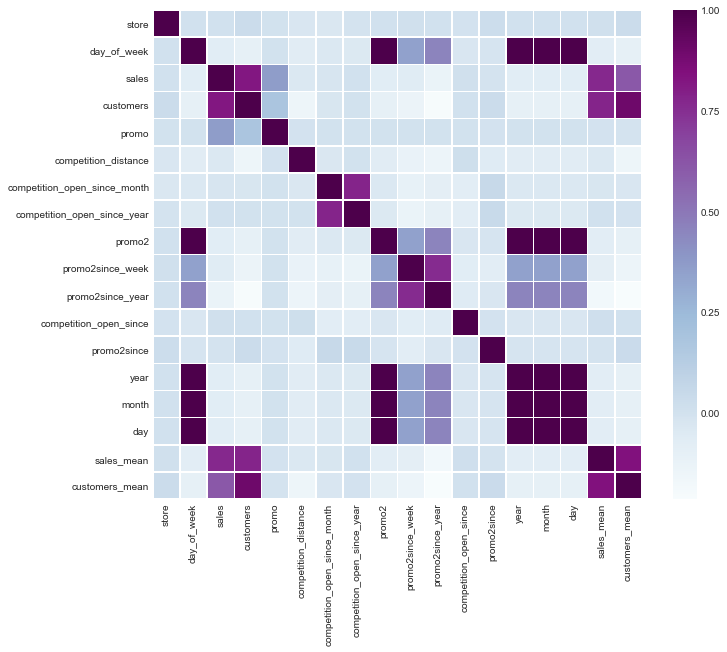

In [7]:

copy = tr_merge.copy()
copy['promo'] = copy.promo.map(int)
copy['promo2'] = copy.promo2.map(int)
copy['year'] = copy.promo2.map(int)
copy['month'] = copy.promo2.map(int)
copy['day'] = copy.promo2.map(int)
copy['day_of_week'] = copy.promo2.map(int)
corr_all = copy.corr()
del copy

# Set up the matplotlib figure
f, ax = plt.subplots(figsize = (11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_all, square = True, linewidths = .5, ax = ax, cmap = "BuPu")      
plt.show()

## Observation
- **Although Pearson Coefficient is for continuous attributes, categorical variables can still be used with Pearson Coefficient under the condition that they show nominal characteristics after being mapped to numbers.**
- Date-related features have high relevance with one another, but these information are not truly useful. And since `promo2` is obtained based on date, it naturally shows high relevance with these features, though not useful for prediction.
- `customers` have significant positive correlation; `sales_mean` is extended from `sales`and thus is significant too. `customs_mean`, extended from `customers` which is highly related to `sales`, surely is significant.
- `promo` has positive linear correlation with `sales` and `customer`; however, we find out that `test.csv` does NOT have the customer column, therefore we cannot serve `customer, customer_mean` features to the model.
- And unfortunately, none of the newly-added `competition_open_since`, `promo2since` has significant linear relation with `sales`. We still use them during training nevertheless.
<br/>
<br/>

<br/>
<br/>
<br/>
<br/>

## Univariate Analysis

<br/>
<br/>
<br/>

### Promo: Take a look at the comparison between normal days and promotion days

promo
0    2.771974e+09
1    3.101206e+09
Name: sales, dtype: float64


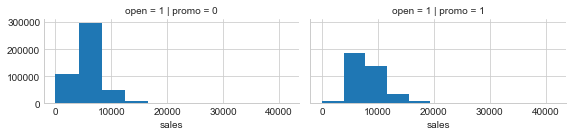

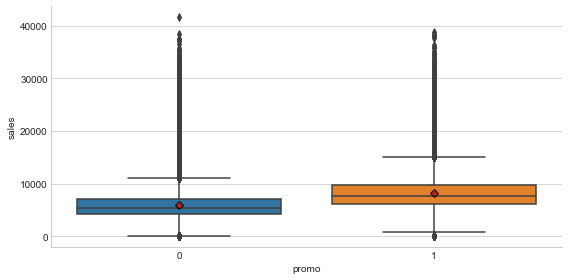

In [87]:
# plt.figure(figsize=(12, 6))
print(tr_merge.groupby('promo').sales.sum())
g = sns.FacetGrid(tr_merge, row='open', col='promo', height=2, aspect=2)
g = g.map(plt.hist, "sales").add_legend()

meanprops = dict(marker='D', markeredgecolor='black', markerfacecolor='firebrick')
sns.catplot(x="promo", y="sales", data=tr_merge, kind="box", height=4, aspect=2, showmeans=True, meanprops=meanprops)

In [88]:
agg = tr_merge.groupby(['promo']).sales.describe()
agg['sum'] = agg['count'] * agg['mean']
agg

,count,mean,std,min,25%,50%,75%,max,sum
promo,,,,,,,,,
0,467496.0,5929.407603,2629.648385,0.0,4242.0,5459.0,7004.0,41551.0,2.771974e+09
1,376896.0,8228.281239,3175.759157,0.0,6069.0,7649.0,9686.0,38722.0,3.101206e+09


Obviously during promotion the number of customers increased, as well as the average expense per customer.
<br/>
<br/>
<br/>

<br/>
<br/>
<br/>

### Whether periodical promotion (promo2) affects revenue

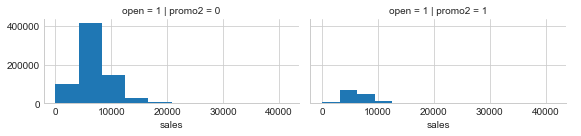

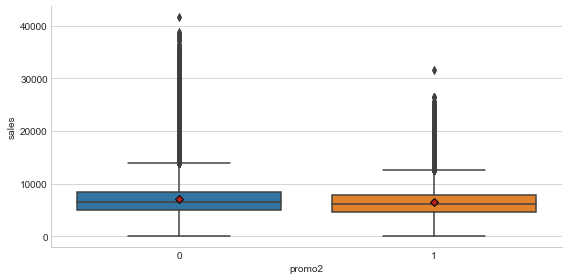

In [89]:
# plt.figure(figsize=(12, 6))
g = sns.FacetGrid(tr_merge, row='open', col='promo2', height=2, aspect=2)
g = g.map(plt.hist, "sales").add_legend()

sns.catplot(x="promo2", y="sales", data=tr_merge, kind="box", height=4, aspect=2, showmeans=True, meanprops=meanprops)

In [90]:
agg = tr_merge.groupby(['promo2']).sales.describe()
agg['sum'] = agg['count'] * agg['mean']
agg

,count,mean,std,min,25%,50%,75%,max,sum
promo2,,,,,,,,,
0,699164.0,7051.816202,3185.964977,0.0,4908.0,6440.0,8476.0,41551.0,4.930376e+09
1,145228.0,6491.892748,2626.976161,0.0,4650.0,6044.0,7837.0,31523.0,9.428046e+08


- Data from `promo2` is clearly less, since promotion does not go on forever (which can be observed in `promo` too). The sales also fails to increase as much as during `promo`.

<br/>
<br/>
<br/>

<br/>
<br/>
<br/>

### DayOfWeek

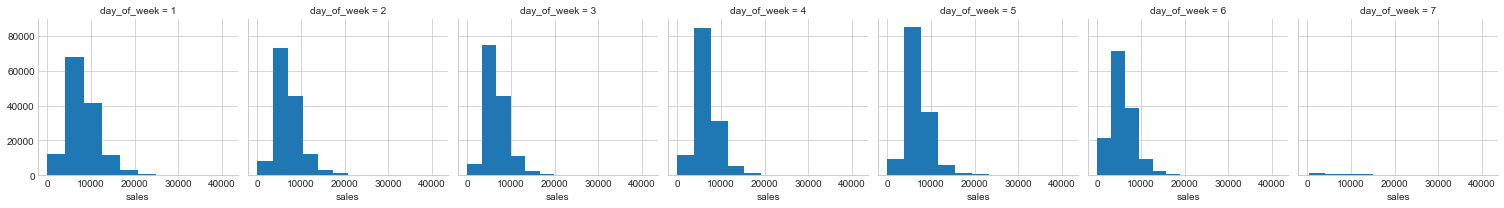

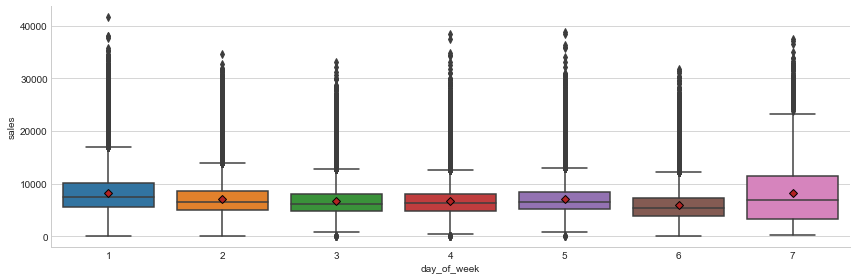

In [91]:
# plt.figure(figsize=(12, 6))
g = sns.FacetGrid(tr_merge, col='day_of_week', sharey=True, height=3, aspect=1)
g = g.map(plt.hist, "sales")

sns.catplot(x="day_of_week", y="sales", data=tr_merge, kind="box", height=4, aspect=3, showmeans=True, meanprops=meanprops)

In [93]:
agg = tr_merge.groupby('day_of_week').sales.describe()
agg['sum'] = agg['count'] * agg['mean']
agg

,count,mean,std,min,25%,50%,75%,max,sum
day_of_week,,,,,,,,,
1,137560.0,8216.073074,3691.768876,0.0,5538.0,7539.0,10133.0,41551.0,1.130203e+09
2,143961.0,7088.113656,3066.237110,0.0,4960.0,6502.0,8521.0,34692.0,1.020412e+09
3,141936.0,6728.122978,2781.775174,0.0,4829.0,6210.0,7987.0,33151.0,9.549629e+08
4,134644.0,6767.310159,2764.548119,0.0,4900.0,6246.0,7987.0,38367.0,9.111777e+08
5,138640.0,7072.677012,2764.915744,0.0,5205.0,6580.0,8324.0,38722.0,9.805559e+08
6,144058.0,5874.840238,2852.730426,0.0,3925.0,5425.0,7232.0,31683.0,8.463177e+08
7,3593.0,8224.723908,6235.152960,286.0,3314.0,6876.0,11418.0,37376.0,2.955143e+07


### Observation
- `day_of_week` = 7 is holiday; while there are still opened shops, `count` is surely low. The average `sales` is however comparable to that of `day_of_week` = 1.

<br/>
<br/>
<br/>

<br/>
<br/>
<br/>
## StoreType

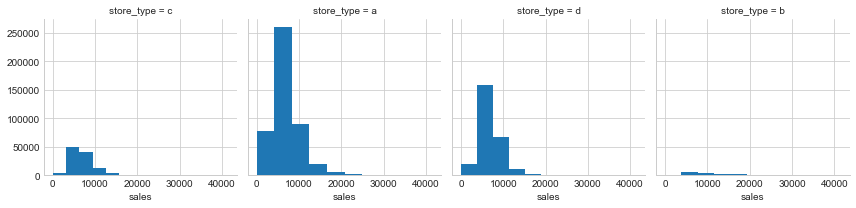

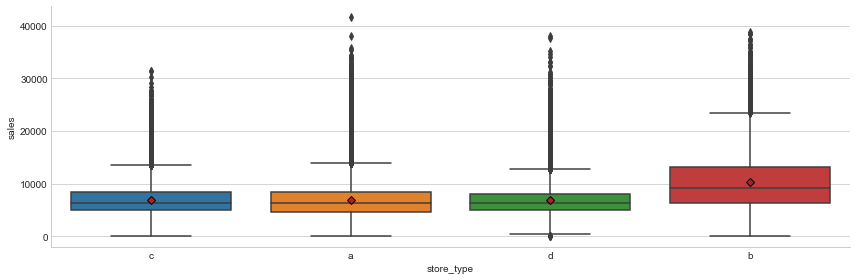

In [96]:
g = sns.FacetGrid(tr_merge, col='store_type', sharey=True, height=3, aspect=1)
g = g.map(plt.hist, "sales")

sns.catplot(x="store_type", y="sales", data=tr_merge, kind="box", height=4, aspect=3, showmeans=True, meanprops=meanprops)

In [97]:
agg = tr_merge.groupby('store_type').sales.describe()
agg['sum'] = agg['count'] * agg['mean']
agg

,count,mean,std,min,25%,50%,75%,max,sum
store_type,,,,,,,,,
a,457077.0,6925.167661,3277.786381,0.0,4695.0,6285.0,8406.0,41551.0,3.165335e+09
b,15563.0,10231.407505,5157.190155,0.0,6344.0,9130.0,13183.5,38722.0,1.592314e+08
c,112978.0,6932.512755,2897.564578,0.0,4915.0,6407.0,8349.0,31448.0,7.832214e+08
d,258774.0,6822.141881,2556.582881,0.0,5050.0,6395.0,8123.0,38037.0,1.765393e+09


### Observation
- Although `store_type` = b has smaller quantity, its `sales` is higher, representing a higher average expense per customer. This is significant information.
- `store_type` = a has the most visiting customers

<br/>
<br/>
<br/>

<br/>
<br/>
<br/>

## Bivariate analysis

### Promo, SchoolHoliday 

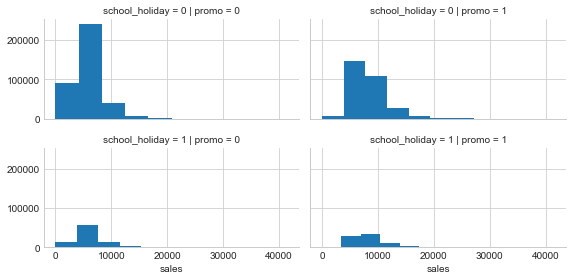

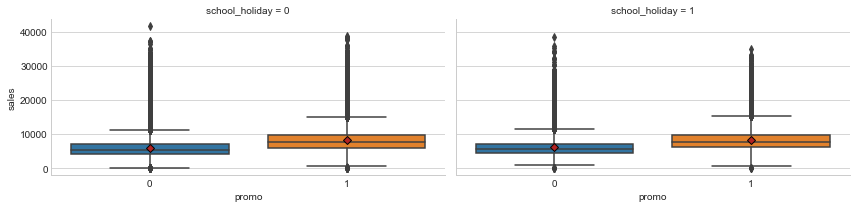

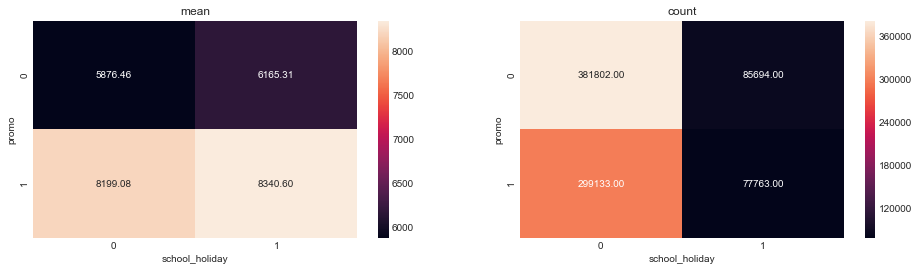

In [100]:
# print(tr_merge.groupby(['Store', 'SchoolHoliday', 'Promo']).Sales.sum())
g = sns.FacetGrid(tr_merge, row='school_holiday', col='promo', height=2, aspect=2)
g = g.map(plt.hist, "sales").add_legend()

sns.catplot(x="promo", y="sales", col='school_holiday', data=tr_merge, kind="box", height=3, aspect=2, showmeans=True, meanprops=meanprops)

utils.heatmap(tr_merge, 'promo', 'school_holiday')

### Observation
- We already knew that `promo` increases `sales`, even though we have fewer data for `school_holiday`. Sales can be seen to increase on `school_holiday`.

<br/>
<br/>
<br/>

### Promo, StateHoliday 

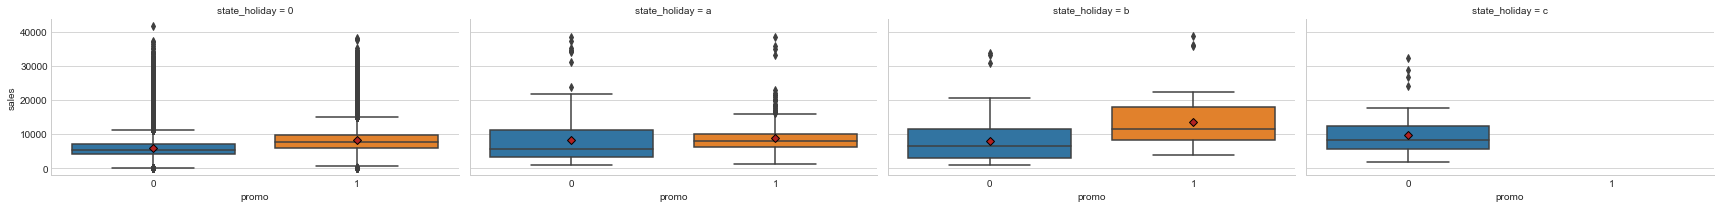

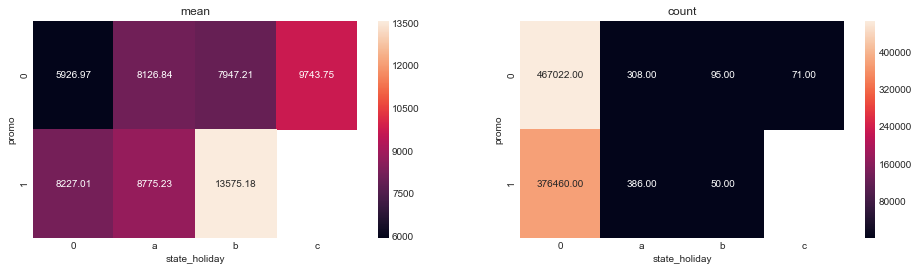

In [102]:
# g = sns.FacetGrid(tr_merge, row='StateHoliday', col='Promo', size=2, aspect=2)
# g = g.map(plt.hist, "Sales").add_legend()

sns.catplot(x="promo", y="sales", col='state_holiday', data=tr_merge, kind="box", height=3, aspect=2, showmeans=True, meanprops=meanprops)
utils.heatmap(tr_merge, 'promo', 'state_holiday')

### Observation
- `state_holiday = 0` has the most amount of data.
-  `sales` has substantial increase when `state_holiday = b` and paired with promotion period, but it exhibits no such phenomenon during normal period. This is also remarkable.
- No data when `state_holiday = c` paired with `promo = 1`.

<br/>
<br/>
<br/>

### StateHoliday, StoreType

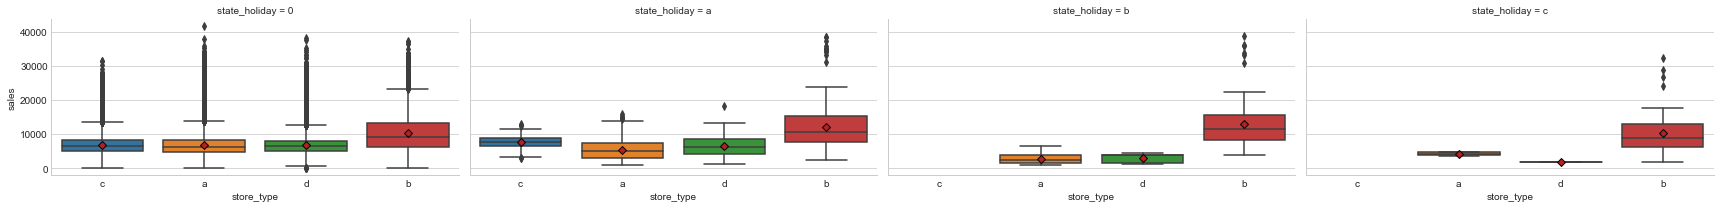

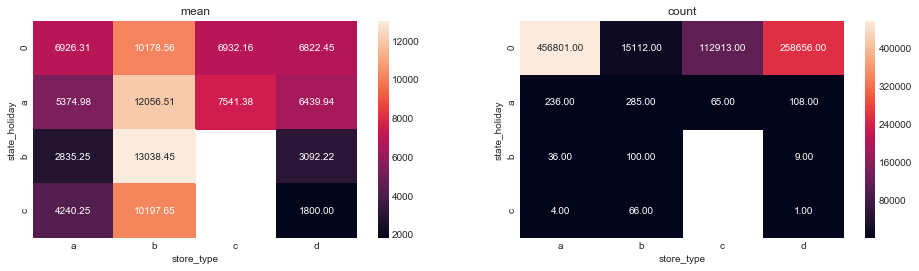

In [111]:
meanprops = dict(marker='D', markeredgecolor='black', markerfacecolor='firebrick')
sns.catplot(x="store_type", y="sales", col='state_holiday', # row='promo', hue='assortment', 
            data=tr_merge, kind="box", height=3, aspect=2, showmeans=True, meanprops=meanprops)
utils.heatmap(tr_merge, 'state_holiday', 'store_type', annot=True)

### Observation
- `stor_type = a` has the most amount of data
- Mean `sales` increases substantially (not data-wise) when `state_holiday = b` paired with `store_type = b`.

<br/>
<br/>
<br/>

### State, StoreType

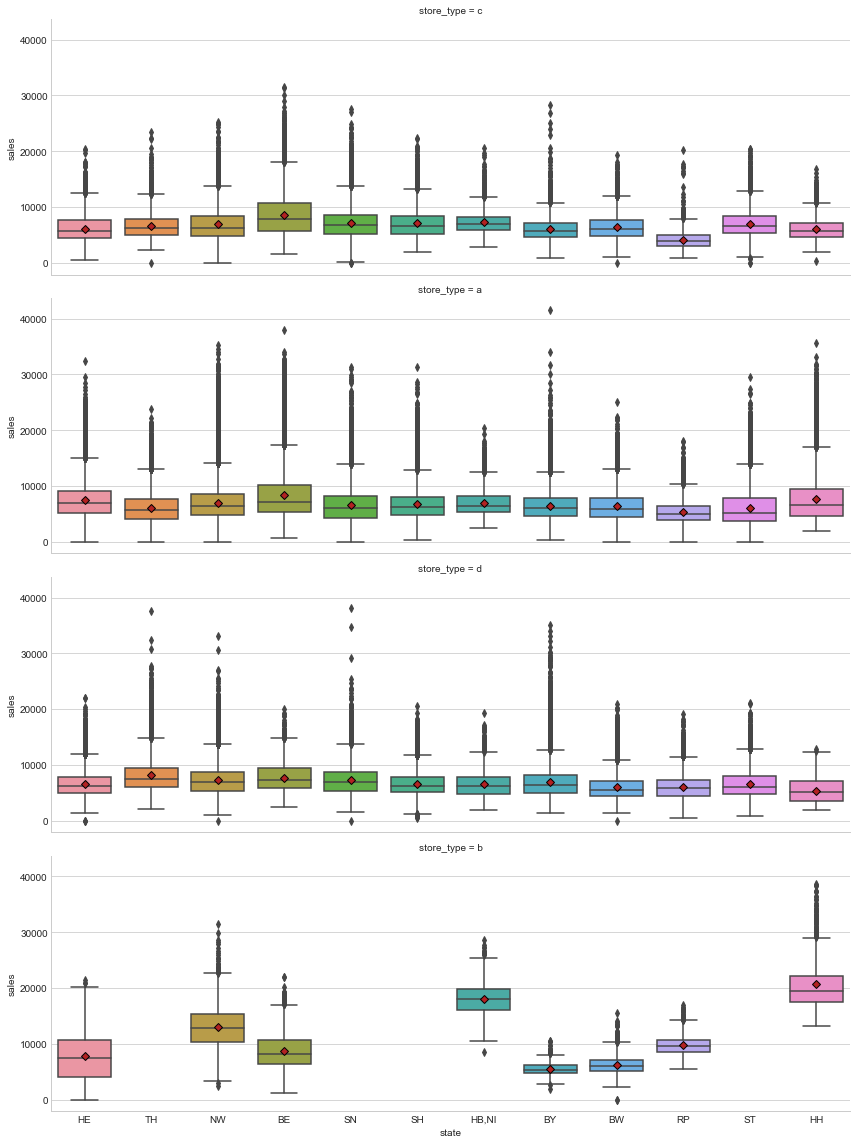

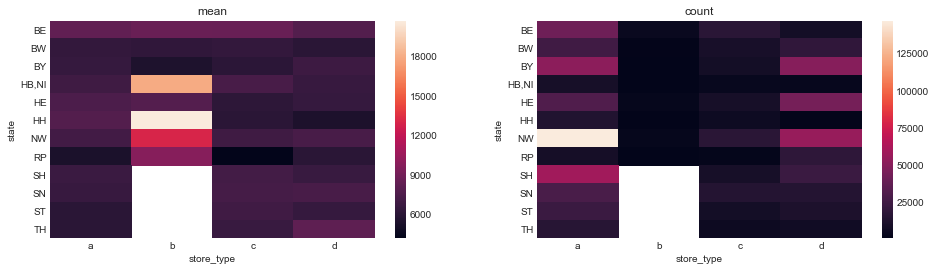

In [104]:
# g = sns.FacetGrid(tr_merge, col='State', row='StoreType', sharey=True, size=4, aspect=.5)
# g = g.map(plt.hist, "Sales")
meanprops = dict(marker='D', markeredgecolor='black', markerfacecolor='firebrick')
sns.catplot(x="state", y="sales", row='store_type', data=tr_merge, kind="box", 
               height=4, aspect=3, showmeans=True, meanprops=meanprops)

utils.heatmap(tr_merge, 'state', 'store_type', annot=False)

### Observation
- Many states do not have sales data for `store_type = b`, but since `state = 'HB,NI' 'HH' 'NW'` have very high average sales, the `store_type = b` still possesses higher average sales in total (resulted from the concentration on certain states).

<br/>
<br/>
<br/>

### Month, Day: We have date in the feature under the assumption that on certain days the sales could be different from normal days

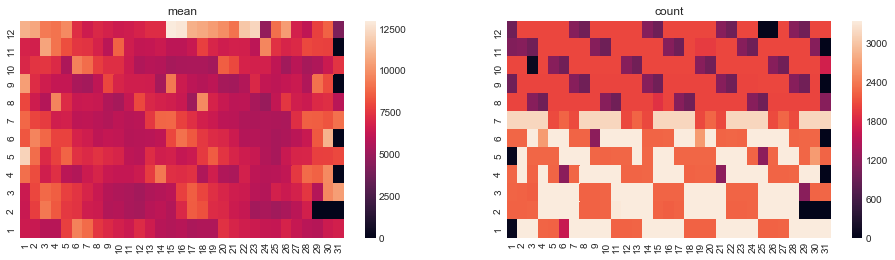

In [126]:
# sns.factorplot(x="day", y="Sales", row='month', data=tr_merge, kind="box", size=4, aspect=3)
xtick = pd.Series(tr_merge.day.unique()).map(int).sort_values().map(str)
ytick = pd.Series(tr_merge.month.unique()).map(int).sort_values(ascending=False).map(str)
utils.heatmap(tr_merge, 'month', 'day', xtick=xtick, ytick=ytick,
              annot=False)

### Observation
- We see fewer customer count after July, but since the data for all shops in the training Data does not go after 2015-07-31, we figure the phenomenon should be resulted from the lack of data starting August during the last year.
- Wee see higher average sales in Mean during `12/15 ~ 12/22`, supposedbly due to Christmas season.

<br/>
<br/>
<br/>

<br/>
<br/>
<br/>

## Multivariate Analysis

### StoreType, StateHoliday, Promo, Assortment

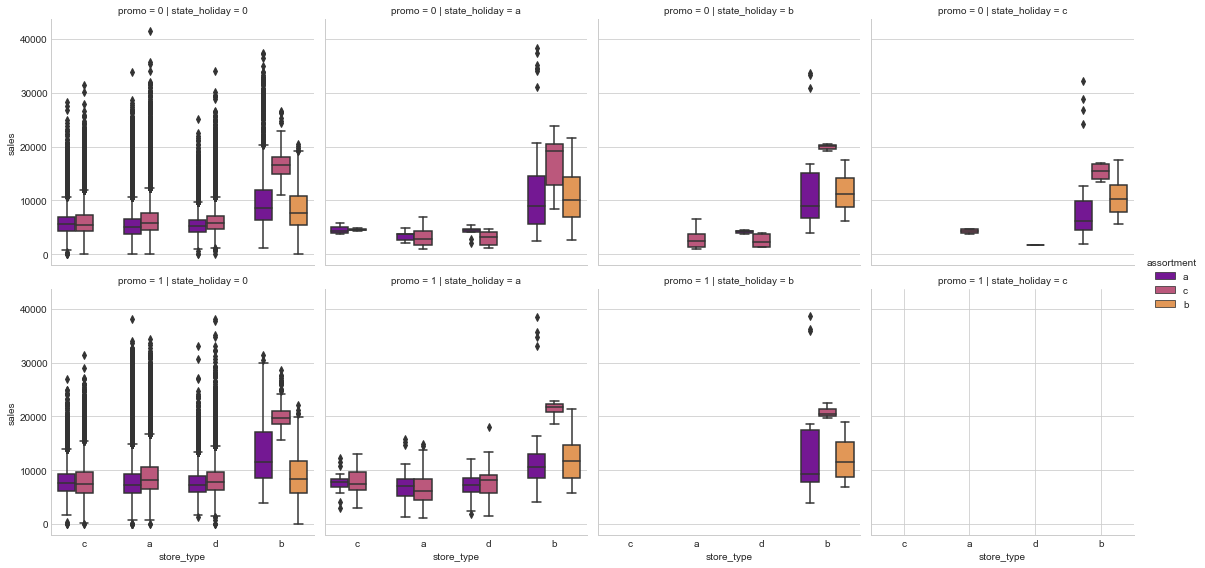

In [132]:
meanprops = dict(marker='D', markeredgecolor='black', markerfacecolor='firebrick')
sns.catplot(data=tr_merge, x='store_type', y="sales", row='promo', col='state_holiday', hue='assortment', 
            kind='box', height=4, palette = 'plasma', meanprops=meanprops)
plt.show()

### Observation
- We had observed that when `state_holiday = b and store_type = b` has the highest average sales; here we add in `assortment` to see that `assortment = c` contributes the most.

<br/>
<br/>
<br/>

### DayOfWeek, Promo, Promo2

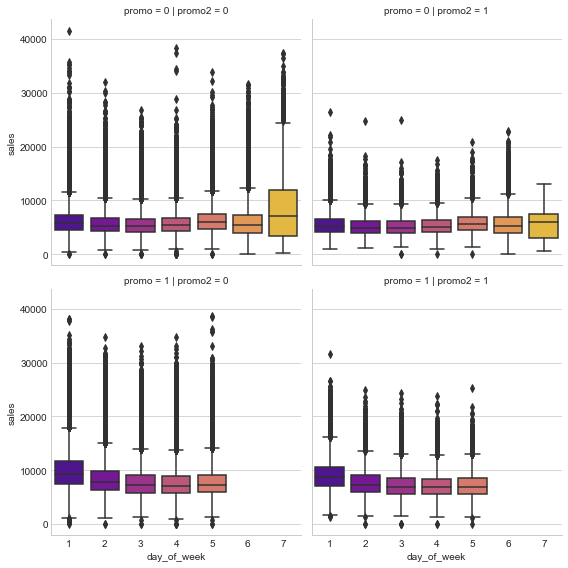

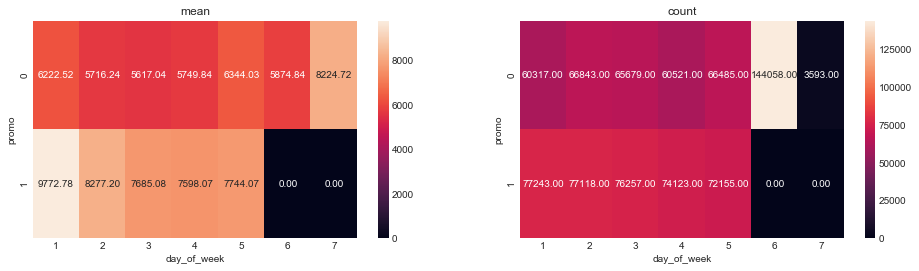

In [137]:
meanprops = dict(marker='D', markeredgecolor='red', markerfacecolor='firebrick')
sns.catplot(data=tr_merge, x='day_of_week', y="sales", row='promo', col='promo2',
            kind='box', height=4, palette = 'plasma', meanprops=meanprops)
plt.show()
utils.heatmap(tr_merge, 'promo', 'day_of_week')

### Observation
- No data exists for `promo = 1 and day_of_week in (6, 7)`. It is peculiar to see no promotion during Saturday and Sunday.
- Saturday has the most customers, but the average sales is modest. Meanwhile, Monday usually has rather high average sales.
- `promo2` has no significant information.

<br/>
<br/>
<br/>

## Data Exploratory Conclusion
- `store_type = a` has the most customers but does not have the highest sales mean.
- `store_type = b` has the highest sales mean, but the contribution of states is highly skewed.
- Date-related features `day_of_week, month, day` have direct impact on sales under certain circumstances, proving to be significant features.
- `state, state_holiday` are significant feature.

<br/>
<br/>
<br/>

## Module structure
    ```
    └─trainer
        │  app_conf.py
        │  ctrl.py
        │  input.py
        │  logging.yaml
        │  metadata.py
        │  model.py
        │  service.py
        └─ utils.py        
    ```
    Directory 'trainer' contains all modules: 
    
|File Name| Purpose
|:---|:---
|[app_conf.py](trainer/app_conf.py) | Applicaiton configures, tell where are the training data, the model checkpoint directory, and hyperparameter suggested to put app_conf.py instead of pass on the fly to controller.
|[ctrl.py](trainer/ctrl.py) |The entrance of the program, accept any parameters, protable for local terminal or restful style environment. 
|[service.py](trainer/service.py) |The business logic module behind the controller(ctrl.py) 
|[utils.py](trainer/utils.py) | Utility module, some common function to put here, like logging function. 
|[metadata.py](trainer/metadata.py)|Defines: 1) task type, 2) input data header, 3) numeric and categorical feature names, 4) target feature name (and labels, for a classification task), and 5) unused feature names. 
|[input.py](trainer/input.py)| Includes: 1) data input functions to read data from csv and tfrecords files, 2) parsing functions to convert csv and tf.example to tensors, 3) function to implement your features custom  processing and creation functionality, and 4) prediction functions (for serving the model) that accepts CSV, JSON, and tf.example instances. 
|[model.py](trainer/model.py)|Includes: 1) function to create DNNRegressor, 2) function to implement for a custom estimator model_fn. 3) include **Feature class** to assign the feature spec, the feature spec usually bind for specific model, so we put them together. 

<br/>
<br/>
<br/>

## Data preprocessing
1. Data is provided in the following format:
    ```
    │  store.csv
    │  store_states.csv
    │  test.csv
    └─ train.csv
    ```
2. We propose 4 steps for the data pipeline during training period : **Clean -> Prepare -> Fit -> Transform(Split)**
    - Clean: 
        - Fill cells with missing value, drop unnecessary features
        - Rename features
        
    - Prepare: 
        - Join 'store' and 'store_states' to make the **Fat table**
        - Add (and drop) features we mentioned in data exploration
        - Filter out unsuitable records, e.g. open = 0
        - Persist certain files

    - Fit: 
        - Persist the statistical information of numeric features
        - Persist the unique count value of categorical features
        
    - Transform:
        - Normalization, logarithm, etc.
        - Convert all categorical variables to int, one-hot encoding, etc.
        - Because the scale of sales is large (hence large standard deviation), **we use the logarithm of the target column**
        
    - Split: in this case we groupby 'store' and order by date, and take 0.3 as the portion of validation data size. That is, the first 70% is used in training and the rest for validation.
        
    ---
    A data preprocess example:
    ```python
    data = self.input.clean(p.fpath, is_serving=False)
    data = self.input.prepare(data, is_serving=False)
    data = self.input.fit(data).transform(data, is_serving=False)
    self.input.split(data)
    ```    
3. What is weird is that the feature `Customers` is not in the test.csv. From the heatmap of Pearson Corr. we know that this feature has linear relation with the target column; it sure is a pity that we have to drop the column.

In [9]:
%%time

p = pd.Series({'fpath': './data/train.csv'})
Ctrl.instance.prepare(p)

2018-08-13 16:02:44,697 - trainer.input - INFO [line:22] - Clean start, is_serving: False
2018-08-13 16:02:50,099 - trainer.input - INFO [line:51] - Clean take time 0:00:05.400786
2018-08-13 16:02:50,131 - trainer.input - INFO [line:55] - Prepare start, is_serving: False
2018-08-13 16:02:50,157 - trainer.input - INFO [line:93] - Persisten store to D:\Python\notebook\ml_specialized\rossmann/data/processed/prepared/store.csv
2018-08-13 16:03:07,365 - trainer.input - INFO [line:134] - Prepare take time 0:00:17.233677
2018-08-13 16:03:07,649 - trainer.input - INFO [line:146] - sales_mean.mean: 5790.497727770823, sales_mean.stdv: 2082.5033707220155, sales_mean.median: 5471.351380042463
2018-08-13 16:03:07,741 - trainer.input - INFO [line:146] - competition_open_since.mean: 14424.153547512962, competition_open_since.stdv: 1805.9849602002341, competition_open_since.median: 14641.0
2018-08-13 16:03:07,837 - trainer.input - INFO [line:146] - promo2since.mean: 15295.40708578792, promo2since.stdv

<br/>
<br/>
<br/>

## Model Structure

![model structure](./model_structure.jpg)

We use Google's `Wide and Deep Model` and DNN Regressor (the Deep Part in the graph) for comparison. When dealing with time serie data having sequential characteristics, one tends to use RNN. However, due to the model complexity of RNN, we prefer using embedding generated for date-related features to extract the pattern or information from data. This way, we deal the time-series data much more easy.

- **Deep Model**
    ```python
    est = tf.estimator.DNNRegressor(
        hidden_units=[128, 64, 32],
        feature_columns=deep_columns,
        model_dir=model_dir,
        label_dimension=1,
        weight_column=None,
        optimizer=tf.train.AdamOptimizer(0.005),
        activation_fn=tf.nn.selu,
        dropout=0.3,
        input_layer_partitioner=None
    )
    ```
    - Loss function: `tf.estimator.DNNRegressor` uses 'mean square error' by default
    - Optimizer: `tf.train.AdamOptimizer` 
    - Overfitting check: Performed during training section. Best checkpoint (`trainer.model.BestScoreExporter`) is used to avoid overfitting.
    - SeLU activation function at each layer (Self Normalization)
    - DNN Structure: `input dim -> 128 -> 64 -> 32 -> 1`, embedding dimension = 3 for all category features except 'store'
    
- **Wide and Deep Model**
    ```python
    est = tf.estimator.DNNLinearCombinedRegressor(
        model_dir=model_dir,
        linear_feature_columns=wide_columns,
        linear_optimizer='Ftrl',
        dnn_feature_columns=deep_columns,
        dnn_optimizer=tf.train.AdamOptimizer(learning_rate),
        dnn_hidden_units=[128, 64, 32],
        dnn_activation_fn=tf.nn.selu,
        dnn_dropout=0.3,
        label_dimension=1
    )
    ```
    - 'Deep' part has the same setting as Deep Model
    - 'Wide' part uses the default [FTRL Optimizer](https://www.tensorflow.org/api_docs/python/tf/train/FtrlOptimizer). For the cross-column part we use the following features:
    ```python
    feature_columns[f'promo_datetime_cross'] = tf.feature_column.crossed_column(
        ['promo', 'promo2', 'year', 'month', 'day', 'day_of_week'], hash_bucket_size=int(1e4))
    feature_columns[f'promo_holiday_cross'] = tf.feature_column.crossed_column(
        ['promo', 'promo2', 'state', 'state_holiday', 'school_holiday'], hash_bucket_size=int(1e4))
    feature_columns[f'store_type_cross'] = tf.feature_column.crossed_column(
        ['state', 'store_type', 'assortment', 'day_of_week'], hash_bucket_size=int(1e4))
    feature_columns[f'competition_cross'] = tf.feature_column.crossed_column(
        ['competition_open_since_month', 'competition_open_since_year'], hash_bucket_size=int(1e4))
    ```
      Basically they are crosses between dates and promotions, betweem differnt holiday types and promotions, lastly between month and year of competition initiated.
      
      <br/>
      
    - During validation, we observe the `RMSPE(Root Mean Square Percentage Error)` error metrics
    $$ \sqrt{\frac{1}{n} \sum^{n}_{i=1} {\frac{y_i - \hat{y_i}}{y_i}}^2} $$
<br/>
<br/>


## Training

We use `tf.estimator.train_and_evaluate` function, which requires `estimator, train_spec, eval_spec` as parameters.
- estimator: `tf.estimator.DNNRegressor` or `tf.estimator.DNNLinearCombinedRegressor`
- train_spec and eval_spec: 
  train_spec and eval_spec both requires a data function that can serve data in batches with an implicit loop. Here we use [tf.data.Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) API for data extraction, which supports multi-core processing to speed up the IO. The example is as follows:
    ```python
    def generate_input_fn(self,
        file_names_pattern, mode, skip_header_lines=False, is_serving=False,
        batch_size=256, num_epochs=1, num_threads=4):

        buffer_size = batch_size * 2
        def _input_fn():
            num_threads = multiprocessing.cpu_count() if multi_threading else 1
            file_names = tf.matching_files(file_names_pattern)

            is_serving = True if mode == tf.estimator.ModeKeys.PREDICT else False
            dataset = tf.data.TextLineDataset(filenames=file_names)
            dataset = dataset.skip(skip_header_lines)
            dataset = dataset.map(lambda csv_row: self.parse_csv(csv_row, is_serving=is_serving))
            dataset = dataset.map(lambda features: self.get_features_target_tuple(features), 
                                  num_parallel_calls=num_threads)
            if shuffle:
                dataset = dataset.shuffle(buffer_size)
            dataset = dataset.batch(batch_size)\
                             .prefetch(buffer_size)\
                             .repeat(num_epochs)
            iterator = dataset.make_one_shot_iterator()
            features, target = iterator.get_next()
            return features, target
        return _input_fn
    ```
  Here, `num_threads` specifies the number of CPU cores for the job.
  
  <br/>
  
  Train, eval spec:
    ```python
    # Train spec
    train_fn = generate_input_fn(...)
    train_spec = tf.estimator.TrainSpec(
        train_fn,
        max_steps=train_steps,
    )
    # Valid spec
    valid_fn = generate_input_fn(...)
    eval_spec = tf.estimator.EvalSpec(
        valid_fn,
        steps=valid_steps,
        exporters=[exporter]
    )
    ```
  The `exporters` in EvalSpec gives you the option of choosing how to export your model during evaluation; instead of using model checkpoint files, we are using [protobufs](https://www.tensorflow.org/extend/tool_developers/#protocol_buffers) files (`.pb`). We can also customize exporter through inheriting `tf.estimator.Exporter` to write your own export logic. Here we implement `BestScoreExporter` from scratch (tensorflow 1.10 now has [BestScoreExporter](https://www.tensorflow.org/api_docs/python/tf/estimator/BestExporter) for you to call directly, unfortunately this was not available at our time of development). During evaluation we compare the metric from previous iterations, such as loss and accuracy; we ONLY export the model if the result from this evaluation is better than the previous ones.
    ```python
    class BestScoreExporter(tf.estimator.Exporter):
        # ...
        def export(self, estimator, export_path, checkpoint_path, eval_result,
             is_the_final_export):

            print(f'eval_result: {eval_result}')
            curloss = eval_result['rmspe']
            if self.best is None or self.best >= curloss:
                estimator.export_savedmodel(
                    export_path,
                    self.serving_input_receiver_fn,
                    assets_extra=self.assets_extra,
                    as_text=self.as_text,
                    checkpoint_path=checkpoint_path)
            else:
                # do nothing
    ```
    While we export the model we also implement an important function, `serving_input_receiver_fn`, to be passed to `tf.estimator.Exporter`. The function is responsible for format transformation, since very often the data format during serving period is not the same as that of data actually sent to the model. The function will return `tf.estimator.export.ServingInputReceiver`. The example is as follows:
    ```python
    def json_serving_input_fn(self):
        # ...
        inputs = {}
        for column in input_feature_columns:
            if column.name in metadata.INPUT_CATEGORICAL_FEATURE_NAMES_WITH_IDENTITY:
                inputs[column.name] = tf.placeholder(shape=[None], dtype=tf.int32, name=column.name)
            else:
                inputs[column.name] = tf.placeholder(shape=[None], dtype=column.dtype, name=column.name)
                
        features = {
            key: tf.expand_dims(tensor, -1)
            for key, tensor in inputs.items()
        }

        return tf.estimator.export.ServingInputReceiver(
            features=self.process_features(features), receiver_tensors=inputs
        )
    ```
    From the metadata above we can see how to define the dtype and shape for placeholders. Transforming `receiver_tensors` to `features` is simply expand one more dimension for each feature; online prediction usually uses JSON format. If we are dealing file in batches, then we can utilize .csv reading functions where we provide at least one .csv filename as the parameters. 'receiver_tensors' could be placeholder with dtype=string, and features are supposedbly in the tensor form recognizable by model.
    
    <br/>
    
- Other settings:
    - Batch size = 256
    - Train steps = 2308 * 8 (about 8 epochs)
    - Valid steps = 989 (about 1 epoch)
    - Drop out rate: 0.3

## Model comparison

We provide four sets of experiments for comparison:
- DNN with hidden layer [128, 64, 32, 1]
- DNN with hidden layer [1024, 512, 256, 1]
- Wide and Deep with hidden layer [128, 64, 32, 1]
- Ridge regression
    - The objective function of ridge regression already contains L2 regularization, which prevents overfitting
    $$ \min_w {\left|\left| X_w - y \right|\right|_2}^2 + \alpha{\left|\left| w \right|\right|_2}^2 $$
    - 'alpha' is the extent of regularization; through experiment we conclude that a value larger than 0.1 would yield better performance on validation data.

### Deep model
- We can change settings in `trainer.app_conf.Config.mlp_layers`

In [ ]:
%%time
params = pd.Series({
    'reset': True,
    'model_name': 'deep'
})
Ctrl.instance.train(params)

### Wide and deep model

In [ ]:
%%time

params = pd.Series({
    'reset': True,
    'model_name': 'wide_and_deep'
})
Ctrl.instance.train(params)

### Ridge Regression

In [3]:
%%time

params = pd.Series({
    'reset': False,
    'model_name': 'ridge'
})
Ctrl.instance.train(params)

2018-08-13 16:38:11,911 - trainer.service - INFO [line:58] - RMSPE on train data: 0.25172015125764613, valid data: 0.3254622870762049
2018-08-13 16:38:11,925 - trainer.service - INFO [line:59] - RMSE on train data: 0.1929401075111576, valid data: 0.20696600800731926
Wall time: 1min 10s


## Model Comparison Observation

We use the logarithm of `sales` for convenience of computation. Also, we observe `RMSPE` in addition to `RMSE` since Kaggle evaluates with the former. We obtain `RMSPE` with np.expm1.

<br/>
<br/>

### We can obtain the following table

------------

   | DNNRegressor | DNNRegressor(large layer dimension) | DNNLinearCombinedRegressor(Wide and Deep) | Scikit-learn Ridge Regression 
---|---
RMSPE | 0.2537  | 0.2669 | **0.2495** | 0.3255
RMSE  | **0.1983** | 0.2067 | 0.2015 | 0.2069


From the RMSPE in the table it seems that Wide and Deep Model performs best, but in this case we will use DNNRegressor, simply because of its comparable results from fewer parameters. In fact, difference less than 0.05 could be safely neglected, since sometimes the same model will produce difference larger than 0.05 after re-training.

<br/>
<br/>
<br/>
<br/>
<br/>
<br/>

## Protocol buffer file inspection
After training the model we use `saved_model_cli` to inspect Protocol Buffers file for a better understanding of the model. Generally, we inspect this file before using model already trained by other developers. Ref: [CLI to inspect SavedModel](https://www.tensorflow.org/guide/saved_model)

In [11]:
export_dir = service.Service.instance.find_latest_expdir('deep')
print( utils.cmd(f'saved_model_cli show --dir {export_dir}') )

The given SavedModel contains the following tag-sets:
serve



In [12]:
export_dir = service.Service.instance.find_latest_expdir('deep')
print( utils.cmd(f'saved_model_cli show --dir {export_dir} --tag_set serve') )

The given SavedModel MetaGraphDef contains SignatureDefs with the following keys:
SignatureDef key: "predict"



In [8]:
export_dir = service.Service.instance.find_latest_expdir('deep')
command = f'saved_model_cli show --dir {export_dir} --tag_set serve --signature_def predict'
print( utils.cmd(command) )

The given SavedModel SignatureDef contains the following input(s):
  inputs['assortment'] tensor_info:
      dtype: DT_STRING
      shape: (-1)
      name: assortment:0
  inputs['competition_distance'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1)
      name: competition_distance:0
  inputs['competition_open_since'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1)
      name: competition_open_since:0
  inputs['competition_open_since_month'] tensor_info:
      dtype: DT_STRING
      shape: (-1)
      name: competition_open_since_month:0
  inputs['competition_open_since_year'] tensor_info:
      dtype: DT_STRING
      shape: (-1)
      name: competition_open_since_year:0
  inputs['day'] tensor_info:
      dtype: DT_STRING
      shape: (-1)
      name: day:0
  inputs['day_of_week'] tensor_info:
      dtype: DT_STRING
      shape: (-1)
      name: day_of_week:0
  inputs['month'] tensor_info:
      dtype: DT_STRING
      shape: (-1)
      name: month:0
  inputs['open'] tensor_inf

### Observation
From the above we can cleary see that the dtype and shape of the data input placeholder can be obtained from an exported .pb files. We can also see the last output node `dnn/logits/BiasAdd:0`

<br/>
<br/>
<br/>

## Serving
The system has to transform raw data before serving it to the model for prediction. The general actions are the same as during the training, while skipping the Fit Phase.
- Clean: Deal with the missing values, drop unneeded columns
- Prepare: Add features as mentioned in feature engineering period
- Transform: Convert column values, normalization of continuous attributes, one-hot encoding for categorical features, etc

## Local prediction
1. Transform raw input data for prediction
    - We call `Ctrl.instance.transform` to transform raw data, followed by merging with `store` to become **Fat Table** for the model to predict
    ```python
    def transform(self, p):
        data = self.input.clean(fpath, is_serving=True)
        data = self.input.prepare(data, is_serving=True)
        data = self.input.transform(data, is_serving=True)
        return data
    ```
    
2. Local prediction
    - call ctrl.local_predict: simply use `tensorflow.contrib.predictor`
        ```python
        from tensorflow.contrib import predictor
        predict_fn = predictor.from_saved_model(export_dir, signature_def_key='predict')
        pred = predict_fn( ... )
        ```
        
3. In this case, we need to take np.expm1 to the prediction result

In [8]:
test_df = Ctrl.instance.transform(pd.Series({'fpath': './data/test.csv'}))
params = pd.Series({
    'datasource': test_df,
    'is_src_file': True,
    'model_name': 'wide_and_deep'
})
pred = Ctrl.instance.local_predict(params)
print(pred)

2018-08-14 09:30:00,603 - trainer.input - INFO [line:22] - Clean start, is_serving: True
2018-08-14 09:30:00,675 - trainer.input - INFO [line:51] - Clean take time 0:00:00.068488
2018-08-14 09:30:00,677 - trainer.input - INFO [line:55] - Prepare start, is_serving: True
2018-08-14 09:30:01,033 - trainer.input - INFO [line:134] - Prepare take time 0:00:00.355044
2018-08-14 09:30:01,035 - trainer.input - INFO [line:166] - Transform start, is_serving: True
2018-08-14 09:30:02,041 - trainer.input - INFO [line:183] - Transform take time 0:00:01.005159
INFO:tensorflow:Restoring parameters from D:\Python\notebook\ml_specialized\rossmann/models/wide_and_deep/export/estimator/1534153112\variables\variables
2018-08-14 09:30:02,854 - tensorflow - INFO [line:115] - Restoring parameters from D:\Python\notebook\ml_specialized\rossmann/models/wide_and_deep/export/estimator/1534153112\variables\variables
[ 5410.  9837. 11814. ...  6582. 20228.  6686.]


In [21]:
test_df.head()

,store,day_of_week,open,promo2,promo,state_holiday,school_holiday,store_type,assortment,state,...,month,day,sales_mean,competition_distance,competition_open_since,competition_open_since_month,competition_open_since_year,promo2since,promo2since_week,promo2since_year
0,1,4,1,0,1,0,0,c,a,HE,...,9,17,4759.096031,1270.0,14123.0,9,2008,15340.0,,
1,3,4,1,0,1,0,0,a,a,NW,...,9,17,6942.568678,14130.0,13483.0,12,2006,14975.0,14,2011
2,7,4,1,0,1,0,0,a,c,SH,...,9,17,8817.050891,24000.0,15796.0,4,2013,15340.0,,
3,8,4,1,0,1,0,0,a,a,SH,...,9,17,5539.358418,7520.0,16344.0,10,2014,15340.0,,
4,9,4,1,0,1,0,0,a,c,NW,...,9,17,6562.337612,2030.0,11170.0,8,2000,15340.0,,


<br/>
<br/>
<br/>

## Deply to ml-engine
- Since the model is to be deployed on ML Engine of GCP, one requires a GCP account to obtain a service account key file, so to access GCP service from your AP server. The `trainer.app_conf.Config.api_key_path` is the path specifying where your key file is stored.
- ML Engine initializes a repository when saving ML model to provide developers the convenience of switching between different versions of model. Here, however, we leave only one version of the model in the repository; while deploying model, all other models previously stored will be deleted.

<br/>
<br/>
<br/>

Appoint key file to the `GOOGLE_APPLICATION_CREDENTIALS` environment variable

In [12]:
%%time
Ctrl.instance.set_client_secret()

2018-08-14 16:03:00,818 - trainer.ctrl - INFO [line:23] - Set env variable [GOOGLE_APPLICATION_CREDENTIALS]
Wall time: 1.99 ms


Here we are uploading the folder of exported model to GCS with path `gs://ml-specialized/rossmann/models`. All GCS buckets are unique, so remember to change the bucket name to your own bucket. Also, select `neu_mf` at `model_path`.

In [15]:
%%time

p = pd.Series({
    # `bucket_name` and `prefix` tell Where to place the model on cloud ==> gs://{bucket_name}/{prefix}
    'bucket_name': 'ml-specialized',
    'prefix': 'rossmann/models',
    'model_path': service.Service.instance.find_latest_expdir('deep'),
})
Ctrl.instance.upload_model(p)

2018-08-14 09:54:09,419 - trainer.ctrl - INFO [line:69] - delete ml-specialized/rossmann/models/saved_model.pb
2018-08-14 09:54:09,514 - trainer.ctrl - INFO [line:69] - delete ml-specialized/rossmann/models/variables/variables.data-00000-of-00001
2018-08-14 09:54:09,603 - trainer.ctrl - INFO [line:69] - delete ml-specialized/rossmann/models/variables/variables.index
2018-08-14 09:54:09,692 - trainer.ctrl - INFO [line:73] - copy D:\Python\notebook\ml_specialized\rossmann\models\dnn_regressor_128_64_32\export\estimator\1534150635/saved_model.pb to rossmann/models/saved_model.pb
2018-08-14 09:54:10,606 - trainer.ctrl - INFO [line:73] - copy D:\Python\notebook\ml_specialized\rossmann\models\dnn_regressor_128_64_32\export\estimator\1534150635\variables/variables.data-00000-of-00001 to rossmann/models/variables/variables.data-00000-of-00001
2018-08-14 09:54:11,191 - trainer.ctrl - INFO [line:73] - copy D:\Python\notebook\ml_specialized\rossmann\models\dnn_regressor_128_64_32\export\estimator

### Deploy
Here is an example of deploying model with RESTful API:
```python
def create_model_ver(self, ml, model_name, deployment_uri):
    model_uri = f'projects/{self.p.project_id}/models/{model_name}'
    now = datetime.now().strftime('%Y_%m_%d__%H_%M_%S')
    version = f'v{now}'
    
    res = ml.projects().models().versions().create(
        parent=model_uri,
        body={
            'name': version,
            'description': 'Regression model use tf.estimator.DNNRegressor',
            'deploymentUri': deployment_uri,
            'runtimeVersion': '1.8'
        }
    ).execute()
    return res
```
- ml: a GCP resource object, usually acquired with
    ```python
    from googleapiclient import discovery

    credentials = GoogleCredentials.get_application_default()
    ml = discovery.build('ml', 'v1', credentials=credentials)
    ```
- deployment_uri: the path for storing GCS model

In [16]:
%%time

p = pd.Series({
    'model_name': 'ml_specilized_rossmann',
    'deployment_uri': 'gs://ml-specialized/rossmann/models'
})
Ctrl.instance.deploy(p)

2018-08-14 10:06:32,312 - googleapiclient.discovery - INFO [line:868] - URL being requested: POST https://ml.googleapis.com/v1/projects/ml-team-cloudmile/models?alt=json
2018-08-14 10:06:32,314 - oauth2client.transport - INFO [line:151] - Attempting refresh to obtain initial access_token
2018-08-14 10:06:32,317 - oauth2client.client - INFO [line:795] - Refreshing access_token
2018-08-14 10:06:35,247 - trainer.service - WARNING [line:180] - <HttpError 409 when requesting https://ml.googleapis.com/v1/projects/ml-team-cloudmile/models?alt=json returned "Field: model.name Error: A model with the same name already exists.">
2018-08-14 10:06:35,257 - googleapiclient.discovery - INFO [line:868] - URL being requested: GET https://ml.googleapis.com/v1/projects/ml-team-cloudmile/models/ml_specilized_rossmann/versions?alt=json
2018-08-14 10:06:35,566 - trainer.service - INFO [line:194] - delete model version [projects/ml-team-cloudmile/models/ml_specilized_rossmann/versions/v2018_08_13__18_03_25]

### Call deployed model
Because of the traffic volume limitation, just show first 100 rows online prediction

---
There are some limitations when using GCP online prediction. For instance, the input placeholders for a model are column-based, while online prediction requires the data to be uploaded in row-based format, as below:
```python
[
    {
        'assortment': 'a',
        'competition_distance': 1270.0,
        'competition_open_since': 14123.0
        ...
    },
    {...}
    {...}
    ...
]
```

In [13]:
test_df = Ctrl.instance.transform(pd.Series({'fpath': './data/test.csv'}))
p = pd.Series({
    'model_name': 'ml_specilized_rossmann',
    'datasource': test_df[:100].to_dict('records')
})
result = Ctrl.instance.online_predict(p)
result

2018-08-14 16:03:03,986 - trainer.input - INFO [line:22] - Clean start, is_serving: True
2018-08-14 16:03:04,049 - trainer.input - INFO [line:51] - Clean take time 0:00:00.061845
2018-08-14 16:03:04,050 - trainer.input - INFO [line:55] - Prepare start, is_serving: True
2018-08-14 16:03:04,438 - trainer.input - INFO [line:134] - Prepare take time 0:00:00.386356
2018-08-14 16:03:04,442 - trainer.input - INFO [line:166] - Transform start, is_serving: True
2018-08-14 16:03:05,271 - trainer.input - INFO [line:183] - Transform take time 0:00:00.827856
2018-08-14 16:03:05,448 - googleapiclient.discovery - INFO [line:868] - URL being requested: POST https://ml.googleapis.com/v1/projects/ml-team-cloudmile/models/ml_specilized_rossmann:predict?alt=json
2018-08-14 16:03:05,449 - oauth2client.transport - INFO [line:151] - Attempting refresh to obtain initial access_token
2018-08-14 16:03:05,475 - oauth2client.client - INFO [line:795] - Refreshing access_token


array([ 5418., 10074., 11115.,  7699.,  8526.,  7836.,  9880., 10642.,  7134.,  6339.,  8701.,
        9631.,  7848.,  9635.,  8414.,  5388.,  7236., 12541., 13406., 12835.,  9435.,  6774.,
        7505.,  5526., 10639., 12520., 10498.,  7837.,  6628.,  6304.,  6350., 12613.,  8131.,
        7282.,  7237.,  7812.,  5371.,  8491.,  5609.,  8048.,  9973.,  6879.,  8619.,  7796.,
        5500.,  7717.,  8886., 12910.,  7673.,  9657.,  9638., 11518.,  8865., 10999.,  6085.,
        6009.,  7782.,  7891., 11682., 10085.,  7426., 10377.,  8997., 11908.,  5467., 15261.,
        6059.,  8270., 10675.,  7450.,  8280.,  8214.,  9767.,  6028.,  5896., 10601.,  9150.,
        8866.,  6460.,  9705., 13715.,  7402.,  5524.,  8263.,  8312., 10132.,  8362.,  4778.,
       10302.,  6899.,  8893.,  9157.,  5651.,  8204.,  6625.,  9503., 12157.,  6563.,  6138.,
        7317.])

<br/>
<br/>
<br/>

## Check Predictions
---
Plot timeline for each store sales. Prev 70% of data is uses for training and the remaining 30% are for validation; predictions are made with validation data and compared with the ground truth.

In [22]:
dtype = inp.Input.instance.get_processed_dtype(is_serving=True)
tr = pd.read_csv('./data/processed/transformed/tr.csv', dtype=dtype).query('open == "1" and sales > 0')
vl = pd.read_csv('./data/processed/transformed/vl.csv', dtype=dtype).query('open == "1" and sales > 0')
# Fill empty string to categorical features
tr = inp.Input.instance.fill_catg_na(tr)
vl = inp.Input.instance.fill_catg_na(vl)
# Add date column for time series inspection
tr['date'] = pd.read_json(app_conf.instance.tr_dt_file, typ='series').values
vl['date'] = pd.read_json(app_conf.instance.vl_dt_file, typ='series').values

tr['predict'] = np.nan
params = pd.Series({
    'datasource': vl.drop(['sales', 'date'], 1),
    'is_src_file': True,
    'model_name': 'deep'
})
vl['predict'] = Ctrl.instance.local_predict(params)

merge = pd.concat([tr, vl], 0)
merge['sales'] = np.expm1(merge.sales)
merge.head()

INFO:tensorflow:Restoring parameters from D:\Python\notebook\ml_specialized\rossmann/models/dnn_regressor_128_64_32/export/estimator/1534150635\variables\variables
2018-08-14 10:11:51,363 - tensorflow - INFO [line:115] - Restoring parameters from D:\Python\notebook\ml_specialized\rossmann/models/dnn_regressor_128_64_32/export/estimator/1534150635\variables\variables


,store,day_of_week,open,promo2,promo,state_holiday,school_holiday,store_type,assortment,state,...,competition_distance,competition_open_since,competition_open_since_month,competition_open_since_year,promo2since,promo2since_week,promo2since_year,sales,date,predict
0,1,3,1,0,0,0,1,c,a,HE,...,1270.0,14123.0,9,2008,15340.0,,,5530.0,2013-01-02,NaN
1,1,4,1,0,0,0,1,c,a,HE,...,1270.0,14123.0,9,2008,15340.0,,,4327.0,2013-01-03,NaN
2,1,5,1,0,0,0,1,c,a,HE,...,1270.0,14123.0,9,2008,15340.0,,,4486.0,2013-01-04,NaN
3,1,6,1,0,0,0,1,c,a,HE,...,1270.0,14123.0,9,2008,15340.0,,,4997.0,2013-01-05,NaN
4,1,1,1,0,1,0,1,c,a,HE,...,1270.0,14123.0,9,2008,15340.0,,,7176.0,2013-01-07,NaN


<br/>
<br/>

Below we can modify the `pos` variable to control the starting position. The following plot will show 3 figures at a time; you can keep running the following 2 cells to view all timeline plots between prediction and label.

In [28]:
pos = 100

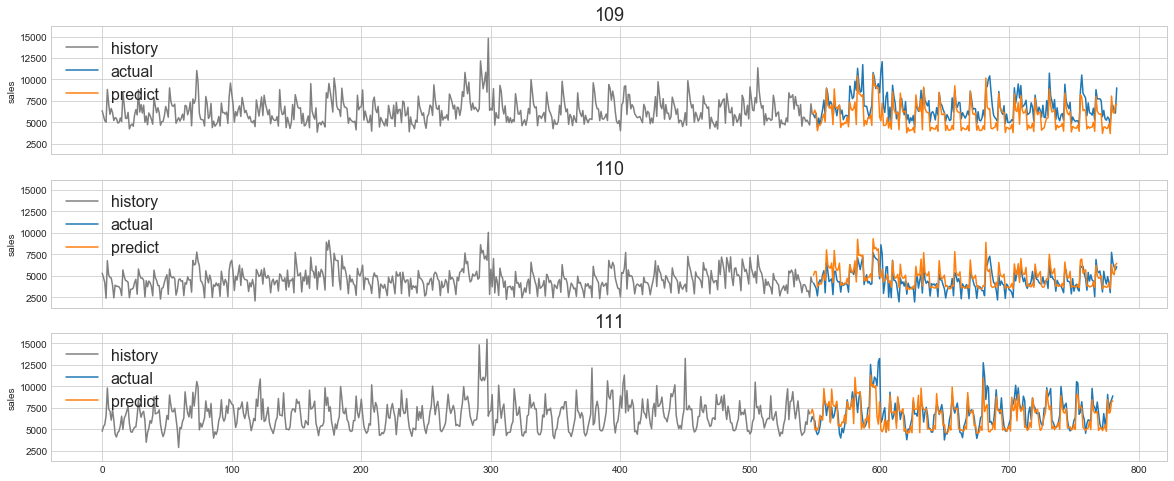

In [32]:
n_rows, n_cols = 3, 1
f, ax = plt.subplots(n_rows, n_cols, figsize=(20, 8), sharex=True, sharey=True)

for r, idx in enumerate(np.arange(pos, pos + n_rows)):
    samples = merge.query(f'store == {idx}').sort_values('date')
    hist = samples[samples.predict.isnull()]
    predict = samples[samples.predict.notnull()]
    ax[r].plot(np.arange(len(hist)), hist.sales.values, c='gray', label='history')
    ax[r].plot(np.arange(len(hist), len(hist) + len(predict)), predict.sales.values, label='actual')
    ax[r].plot(np.arange(len(hist), len(hist) + len(predict)), predict.predict.values, label='predict')
    ax[r].set_title(f'{idx}', size=18)
    ax[r].set_ylabel('sales')
    ax[r].set_ylabel('sales')
    ax[r].grid(True)
    ax[r].legend(loc='best', prop={'size': 16})
pos += n_rows
plt.show()

### Observation

The title of each figure is the store ID. The grey part is the timeline for the training data, while the timeline in blue is the actual sales, with predictions in orange. It is clear that the prediction matches nicely with the trend, even for the peak event.